<a href="https://colab.research.google.com/github/roberto-musa/dl_ai0725/blob/main/ProgettoDLRivisto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1	Preparazione dell’ambiente**
Abbiamo scelto di sfruttare come ambiente Google Colab (alternato in fase preparatoria conni Notebook Kaggle per problemi prestazionali), permettendoci di fruire subito di Python, notebook Jupiter, shell bash ed un ambiente virtuale di esecuzione.
Il progetto è iniziato montando Google Drive e definendo un path per contenere codice e dati.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/FruitDLProj
!mkdir -p /content/drive/MyDrive/FruitDLProj/models
# Crea i path qualora non esistano

!curl -L -o /content/drive/MyDrive/FruitDLProj/fruits.zip\ https://www.kaggle.com/api/v1/datasets/download/moltean/fruits
!unzip /content/drive/MyDrive/FruitDLProj/fruits.zip -d /content/drive/MyDrive/FruitDLProj/frutti
!ls /content/drive/MyDrive/FruitDLProj/frutti

fruits-360_100x100	   fruits-360_dataset_meta  fruits-360_original-size
fruits-360_3-body-problem  fruits-360_multi


# **1.1	CPU vs GPU**
Il parallelismo offerto da una GPU permette un addestramento più efficiente del nostro modello per cui, visto anche il carico che abbiamo rilevato nel corso del progetto, è fondamentale verificare di operare con esse, per cui abbiamo eseguito il seguente codice:


In [ ]:
import tensorflow as tf

# Verifica se TensorFlow ha rilevato una GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Configura la crescita della memoria (sebbene non sia fondamentale è una buona pratica)
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU rilevata: {gpus[0]}")
    print("Il tuo modello verrà addestrato sulla GPU.")
  except RuntimeError as e:
    # Errore di inizializzazione della GPU
    print(e)
    print("Errore durante l'inizializzazione della GPU. Il modello potrebbe usare la CPU.")
else:
  print("Nessuna GPU rilevata. Il tuo modello verrà addestrato sulla CPU.")

# Stampa la versione di TensorFlow (utile per debugging) print(f"Versione di TensorFlow: {tf. version }")

GPU rilevata: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Il tuo modello verrà addestrato sulla GPU.


# **2	Esplorazione dei dati**
Prima di iniziare ad esplorare i dati faremo una prima semplificazione andando ad aggregare le classi limitandoci a distinguere, ad esempio, una mela da una pera, senza operare ulteriori distinzioni fra le varie sottoclassi per ogni frutto.

In [ ]:
import os
import shutil # Per copiare/spostare file

# 2.1 Percorsi del dataset originale
dataset_root = '/content/drive/MyDrive/FruitDLProj/frutti/fruits-360_100x100/fruits-360'
train_dir_original = os.path.join(dataset_root, 'Training')
test_dir_original = os.path.join(dataset_root, 'Test')

# 2.2 Nuovi percorsi per il dataset aggregato
aggregated_dataset_root = '/content/drive/MyDrive/FruitDLProj/frutti/aggregati'
train_dir_aggregated = os.path.join(aggregated_dataset_root, 'Training')
test_dir_aggregated = os.path.join(aggregated_dataset_root, 'Test')

print(f"Dataset originale da: {dataset_root}")
print(f"Salvataggio dataset aggregato in: {aggregated_dataset_root}")
print("-" * 50)

# 2.3. Definizione della funzione per aggregare i nomi delle classi
def aggregate_fruit_name(folder_name):
    aggregated_name = folder_name.split(' ')[0]
    # Mappatura per 'Nut' e 'Hazelnut' a 'nut'
    if aggregated_name == 'Walnut':
        aggregated_name = 'Nut'
    elif aggregated_name == 'Hazelnut':
        aggregated_name = 'Nut'
    return aggregated_name.lower()

# 2.4. Definizione della funzione per creare directory e copiare immagini
def create_and_populate_aggregated_dataset(original_base_dir, aggregated_base_dir, aggregator_func):
    """
    Crea la struttura delle directory aggregate e copia le immagini.
    """
    print(f"Preparazione directory per {os.path.basename(original_base_dir)} aggregato...")
    if os.path.exists(aggregated_base_dir):
        print(f"  Esco per non sovrascrivere accidentalmente la vecchia directory '{aggregated_base_dir}'...")
        exit() #aggiunto
        # print(f"  Rimuovendo la vecchia directory '{aggregated_base_dir}'...")
        # shutil.rmtree(aggregated_base_dir) # Rimuovi la directory esistente per ricrearla pulita
    os.makedirs(aggregated_base_dir) # Crea la directory base per il set aggregato

    image_count = 0
    # Processa le cartelle di classe originali
    for original_class_folder in os.listdir(original_base_dir):
        original_class_path = os.path.join(original_base_dir, original_class_folder)

        if os.path.isdir(original_class_path):
            aggregated_label = aggregator_func(original_class_folder)
            target_class_dir = os.path.join(aggregated_base_dir, aggregated_label)

            # Crea la sottocartella per la classe aggregata se non esiste
            os.makedirs(target_class_dir, exist_ok=True) # exist_ok=True evita errori se esiste già

            # Copia le immagini nella nuova cartella aggregata
            for img_name in os.listdir(original_class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src_img_path = os.path.join(original_class_path, img_name)
                    dest_img_path = os.path.join(target_class_dir, img_name)
                    shutil.copy(src_img_path, dest_img_path) # Copia il file
                    image_count += 1
    print(f"  Completato. Copiate {image_count} immagini in {aggregated_base_dir}.")
    return image_count

# 2.5. Esecuzione della creazione e popolamento del dataset aggregato ---
print("Inizio creazione dataset aggregato...")
total_train_images_copied = create_and_populate_aggregated_dataset(
    train_dir_original, train_dir_aggregated, aggregate_fruit_name
)
total_test_images_copied = create_and_populate_aggregated_dataset(
    test_dir_original, test_dir_aggregated, aggregate_fruit_name
)
print(f"Totale immagini Training aggregate copiate: {total_train_images_copied}")
print(f"Totale immagini Test aggregate copiate: {total_test_images_copied}")
print("-" * 50)


Dataset originale da: /content/drive/MyDrive/FruitDLProj/frutti/fruits-360_100x100/fruits-360
Salvataggio dataset aggregato in: /content/drive/MyDrive/FruitDLProj/frutti/aggregati
--------------------------------------------------
Inizio creazione dataset aggregato...
Preparazione directory per Training aggregato...
  Rimuovendo la vecchia directory '/content/drive/MyDrive/FruitDLProj/frutti/aggregati/Training'...
  Completato. Copiate 103993 immagini in /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Training.
Preparazione directory per Test aggregato...
  Completato. Copiate 34711 immagini in /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Test.
Totale immagini Training aggregate copiate: 103993
Totale immagini Test aggregate copiate: 34711
--------------------------------------------------
DataFrame di training creato dal dataset aggregato con 74 classi.
DataFrame di test creato dal dataset aggregato con 74 classi.
--------------------------------------------------


Separiamo la definizione dei DataFrame in modo da non dover eseguire ogni volta l’aggregazione con la creazione della struttura e copia delle immagini.

In [ ]:
import os
import pandas as pd

# Nuovi percorsi per il dataset aggregato
aggregated_dataset_root = '/content/drive/MyDrive/FruitDLProj/frutti/aggregati'
train_dir_aggregated = os.path.join(aggregated_dataset_root, 'Training')
test_dir_aggregated = os.path.join(aggregated_dataset_root, 'Test')

# 2.6. Creazione dei DataFrame df_train e df_test
# Conteggio delle classi aggregate nel dataset
train_image_counts = {}
for aggregated_class_folder in os.listdir(train_dir_aggregated):
    class_path = os.path.join(train_dir_aggregated, aggregated_class_folder)
    if os.path.isdir(class_path):
        train_image_counts[aggregated_class_folder] = len(os.listdir(class_path))

test_image_counts = {}
for aggregated_class_folder in os.listdir(test_dir_aggregated):
    class_path = os.path.join(test_dir_aggregated, aggregated_class_folder)
    if os.path.isdir(class_path):
        test_image_counts[aggregated_class_folder] = len(os.listdir(class_path))

df_train = pd.DataFrame(train_image_counts.items(), columns=['Classe', 'Numero Immagini'])
df_test = pd.DataFrame(test_image_counts.items(), columns=['Classe', 'Numero Immagini'])

print("-" * 50)
print(f"DataFrame di training creato dal dataset aggregato con {len(df_train)} classi.")
print(f"DataFrame di test creato dal dataset aggregato con {len(df_test)} classi.")
print("-" * 50)

--------------------------------------------------
DataFrame di training creato dal dataset aggregato con 74 classi.
DataFrame di test creato dal dataset aggregato con 74 classi.
--------------------------------------------------


# **2.1	Esplorazione visiva**
Aggregati i dati in macro-classi procediamo all’analisi visiva dei dati andando a generare delle nuvole di punti. Per poter visualizzare i dati come nuvola di punti, dovremo operare una riduzione della loro dimensionalità, ad esempio t-SNE, avendo dati ad alta dimensione come risultato dell’analisi di immagini.

**Tramite la nuvola di punti miriamo a valutare:**

* Cluster distinti: Se le immagini della stessa classe si raggruppano strettamente e sono ben separate da quelle di altre classi, questo indica che le feature estratte sono linearly separable o comunque ben discriminabili. Questo sarebbe una situazione ottimale per il nostro modello di classificazione.
* Cluster sovrapposti/mescolati: Se le nuvole di punti di classi diverse si sovrappongono significativamente, significa che in quello spazio a bassa dimensionalità (con la riduzione t-SNE operata) quelle classi sono molto simili e difficili da distinguere, portando il nostro modello ad affrontare difficoltà a classificare correttamente le immagini.
* Outliers/Errori: Eventuali punti isolati di un colore all'interno del cluster di un altro colore, indicano immagini atipiche o potenziali errori nelle etichette.
* Diversità intrinseca delle immagini su base RGB: Tenendo conto che abbiamo applicato t-SNE direttamente sui pixel appiattiti, la nuvola di punti mostra quanto sono intrinsecamente diverse le immagini stesse basandosi sui loro valori RGB.
* Qualità delle immagini e del pre-processing: Se un cluster è inaspettatamente mescolato, potrebbe esserci un problema nel pre-processing o nella qualità delle immagini per quella classe.

# **2.1.1 Riduzione di Dimensionalità con t-SNE**
Prima di poter visualizzare la nuvola di punti è fondamentale pre-elaborare i DataFrame di input (che conterranno feature numeriche ed una colonna di etichette) per generare nuovi DataFrame con le coordinate 2D (Componente 1, Componente 2) pronte per la visualizzazione come nuvola di punti.

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image # Necessaria per caricare e manipolare le immagini
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
import random # Per il campionamento casuale delle immagini

# Silenziamo gli avvisi (purtroppo comuni in Colab)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Per rimediare all'avviso OpenBLAS, si possono decommentare queste righe per modificare le variabili d'ambiente:
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"

# 3.1. Configurazione dei Percorsi e Parametri
aggregated_dataset_root = '/content/drive/MyDrive/FruitDLProj/frutti/aggregati'
train_dir_aggregated = os.path.join(aggregated_dataset_root, 'Training')
test_dir_aggregated = os.path.join(aggregated_dataset_root, 'Test')

# Parametri per il pre-processing delle immagini per t-SNE
IMAGE_SIZE_FOR_TSNE = (64, 64) # Larghezza, Altezza (es. 64x64 pixel)
# Limitiamo il numero di immagini per classe per t-SNE. T-SNE è lento su dataset molto grandi.
MAX_SAMPLES_PER_CLASS_FOR_TSNE = 200 # Campiona fino a 200 immagini per ogni classe per t-SNE.

print(f"Dataset aggregato da cui caricare le immagini: {aggregated_dataset_root}")
print(f"Immagini ridimensionate a: {IMAGE_SIZE_FOR_TSNE[0]}x{IMAGE_SIZE_FOR_TSNE[1]} per t-SNE.")
print(f"Max campioni per classe per t-SNE: {MAX_SAMPLES_PER_CLASS_FOR_TSNE}")
print("-" * 50)

# 3.2. Definiamo la funzione per Caricare i Percorsi delle Immagini e le Etichette da Cartelle Aggregate
# Questa funzione creerà i DataFrame iniziali con 'filepaths' e 'labels'.
def load_aggregated_dataset_to_dataframe(base_dir, max_samples_limit=None):
    filepaths = []
    labels = []

    print(f"Caricamento percorsi da: {base_dir}")
    # Itera sulle cartelle di classe all'interno della directory base (es. 'apple', 'banana')
    for aggregated_class_folder in os.listdir(base_dir):
        class_path = os.path.join(base_dir, aggregated_class_folder)
        if os.path.isdir(class_path):
            img_names = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(img_names) # Mescola per un campionamento casuale

            # Applica il limite di campioni per classe per t-SNE, se definito
            if max_samples_limit and len(img_names) > max_samples_limit:
                img_names = random.sample(img_names, max_samples_limit)

            for img_name in img_names:
                filepaths.append(os.path.join(class_path, img_name))
                labels.append(aggregated_class_folder.lower()) # L'etichetta è il nome della cartella aggregata

    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Carica i DataFrame con i percorsi delle immagini e le etichette aggregate
df_train_paths = load_aggregated_dataset_to_dataframe(train_dir_aggregated, MAX_SAMPLES_PER_CLASS_FOR_TSNE)
df_test_paths = load_aggregated_dataset_to_dataframe(test_dir_aggregated, MAX_SAMPLES_PER_CLASS_FOR_TSNE)

print(f"\nDataFrame di training (percorsi) caricato: {len(df_train_paths)} immagini.")
print(f"DataFrame di test (percorsi) caricato: {len(df_test_paths)} immagini.")
print("-" * 50)


# 3.3. Definiamo la funzione per Caricare, Pre-processare e Appiattire le Immagini
# Questa funzione prende un DataFrame di percorsi e restituisce un DataFrame di feature appiattite.
def load_and_flatten_images(dataframe_paths, image_size):
    print(f"Caricamento e pre-processing di {len(dataframe_paths)} immagini per t-SNE...")
    features_list = [] # Qui verranno memorizzati i vettori di pixel appiattiti
    labels_list = []

    for index, row in dataframe_paths.iterrows():
        try:
            img_path = row['filepaths']
            label = row['labels']

            img = Image.open(img_path).convert('RGB') # Carica l'immagine e la converte in RGB
            img = img.resize(image_size) # Ridimensiona alla dimensione target
            img_array = np.array(img) / 255.0 # Converte in array NumPy e normalizza i pixel [0, 1]
            features_list.append(img_array.flatten()) # Appiattisce l'array dell'immagine in un vettore 1D
            labels_list.append(label)
        except Exception as e:
            print(f"ATTENZIONE: Saltata immagine '{img_path}' a causa di errore: {e}")

    return pd.DataFrame({'features': features_list, 'labels': labels_list})

# Applica la funzione per ottenere i DataFrame con le feature delle immagini appiattite
df_flattened_features_train = load_and_flatten_images(df_train_paths, IMAGE_SIZE_FOR_TSNE)
df_flattened_features_test = load_and_flatten_images(df_test_paths, IMAGE_SIZE_FOR_TSNE)

print(f"\nDataFrame con feature appiattite di training creato: {len(df_flattened_features_train)} campioni.")
if not df_flattened_features_train.empty:
    print(f"Dimensione feature (per immagine): {df_flattened_features_train['features'].iloc[0].shape[0]}")
print(f"DataFrame con feature appiattite di test creato: {len(df_flattened_features_test)} campioni.")
if not df_flattened_features_test.empty:
    print(f"Dimensione feature (per immagine): {df_flattened_features_test['features'].iloc[0].shape[0]}")
print("-" * 50)


# 3.4. Definiamo la funzione per Applicare t-SNE a un DataFrame di Feature Appiattite

def apply_tsne_to_flattened_features(dataframe_features, feature_column, label_column, n_components=2):
    print(f"Applicazione di t-SNE a {len(dataframe_features)} campioni...")

    # Prepara la matrice di feature (X) e il vettore di etichette (y)
    X = np.vstack(dataframe_features[feature_column].values) # Stacka i vettori delle feature in una matrice 2D
    y = dataframe_features[label_column].values

    # Scala i dati (StandardScaler è cruciale per t-SNE)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Applica t-SNE
    # I parametri perplexity, n_iter e learning_rate sono importanti parametri da ottimizzare.
    tsne = TSNE(n_components=n_components, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)
    tsne_results = tsne.fit_transform(X_scaled)
    print("t-SNE completato.")

    # Crea un nuovo DataFrame con i risultati di t-SNE e le etichette originali
    column_names = [f'Componente {i+1}' for i in range(n_components)]
    tsne_df = pd.DataFrame(tsne_results, columns=column_names)
    tsne_df['Classe'] = y # Aggiungi le etichette di classe

    # La colonna 'Classe' deve essere di tipo categorico per un plotting migliore
    tsne_df['Classe'] = pd.Categorical(tsne_df['Classe'], categories=tsne_df['Classe'].unique(), ordered=False)

    print(f"DataFrame ridotto creato con shape: {tsne_df.shape}")
    return tsne_df


# 3.5. Esecuzione dell'Applicazione di t-SNE ai Dati
print("Inizio applicazione t-SNE ai dati di training e test (feature appiattite)...")

# Applica t-SNE al DataFrame delle feature appiattite del training set
df_tsne_train = apply_tsne_to_flattened_features(df_flattened_features_train, 'features', 'labels')

# Applica t-SNE al DataFrame delle feature appiattite del test set
df_tsne_test = apply_tsne_to_flattened_features(df_flattened_features_test, 'features', 'labels')

print("\nDataFrame con dimensionalità ridotta per il plotting:")
print("df_tsne_train (prime 5 righe):\n", df_tsne_train.head())
print("\ndf_tsne_test (prime 5 righe):\n", df_tsne_test.head())
print("-" * 50)

# df_tsne_train e df_tsne_test sono ora pronti per il plotting


Dataset aggregato da cui caricare le immagini: /content/drive/MyDrive/FruitDLProj/frutti/aggregati
Immagini ridimensionate a: 64x64 per t-SNE.
Max campioni per classe per t-SNE: 200
--------------------------------------------------
Caricamento percorsi da: /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Training
Caricamento percorsi da: /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Test

DataFrame di training (percorsi) caricato: 14751 immagini.
DataFrame di test (percorsi) caricato: 12673 immagini.
--------------------------------------------------
Caricamento e pre-processing di 14751 immagini per t-SNE...
Caricamento e pre-processing di 12673 immagini per t-SNE...

DataFrame con feature appiattite di training creato: 14751 campioni.
Dimensione feature (per immagine): 12288
DataFrame con feature appiattite di test creato: 12673 campioni.
Dimensione feature (per immagine): 12288
--------------------------------------------------
Inizio applicazione t-SNE ai dati di training

# **2.1.2	Plotting dei dati pre-processati**
Con i dati pre-processati per la visualizzazione come nuvola di punti andiamo ora a fare il plotting per esaminare gli schemi che possono emergere dalla visualizzazione dei dati.

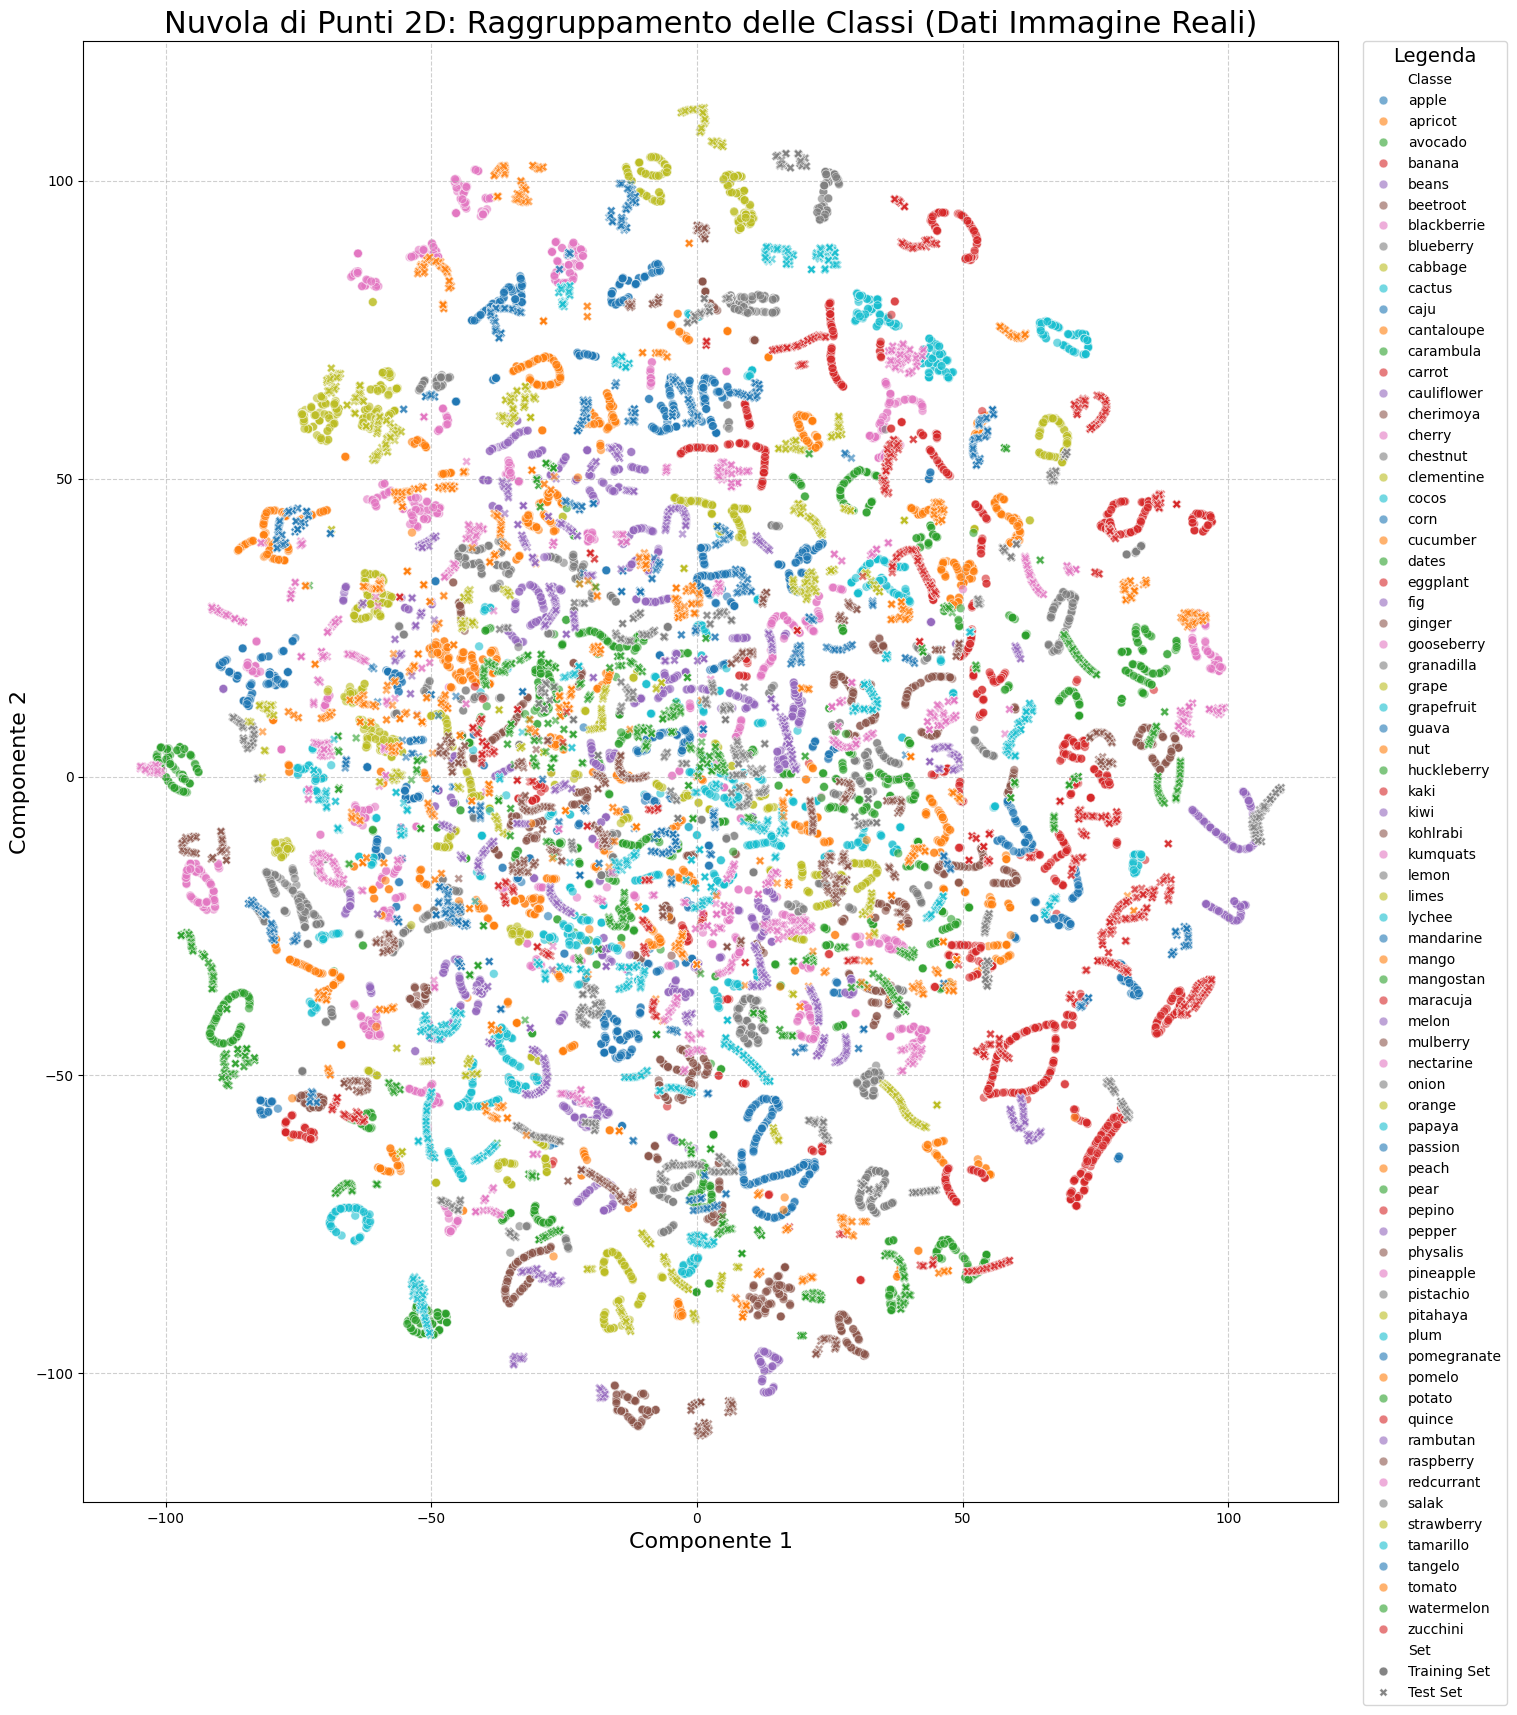


Nuvola di punti 2D generata con visualizzazione migliorata!


In [ ]:
#Il seguente codice presenta delle migliorie per la visualizzazione rispetto
# ad una precedente versione

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preparazione dei dati per il plotting
df_tsne_train['Set'] = 'Training Set'
df_tsne_test['Set'] = 'Test Set'
df_combined_tsne = pd.concat([df_tsne_train, df_tsne_test], ignore_index=True)

# Impostazioni per una Migliore Visualizzazione

# Aumenta la dimensione della figura per un grafico più grande
plt.figure(figsize=(18, 18)) # Aumentato da (14, 10) a (18, 18)

# Crea lo scatter plot
ax = sns.scatterplot( # Assegna l'oggetto axes a una variabile per un controllo più fine
    x='Componente 1',
    y='Componente 2',
    hue='Classe',         # Colora i punti in base alla classe
    style='Set',          # Usa marker diversi per distinguere Training/Test
    data=df_combined_tsne,
    # Palette da provare se 'tab10' non ha abbastanza colori distinti per le classi
    # 'viridis', 'plasma', 'cividis', 'magma' sono palette graduate
    # 'Set3', 'Paired', 'Accent' sono palette con più colori discreti
    palette='tab10',
    legend='full',        # Mostra la legenda completa
    alpha=0.6,            # Riduce leggermente l'alpha per gestire la sovrapposizione dei punti
    s=40                  # Riduce la dimensione dei punti per evitare sovrapposizioni e migliorare la densità visiva (da 70 a 40)
)

# Aumenta la dimensione del font per il titolo e le etichette degli assi
plt.title('Nuvola di Punti 2D: Raggruppamento delle Classi (Dati Immagine Reali)', fontsize=22) # Aumentato da 18 a 22
plt.xlabel('Componente 1', fontsize=16) # Aumentato da 14 a 16
plt.ylabel('Componente 2', fontsize=16) # Aumentato da 14 a 16

plt.grid(True, linestyle='--', alpha=0.6)

# Regola la legenda per un aspetto migliore
# Sposta la legenda fuori dal plot per non coprire i punti.
# `bbox_to_anchor` e `loc` controllano la posizione, `borderaxespad` il padding.
# Aumenta la dimensione del font nella legenda se necessario.
plt.legend(title='Legenda', title_fontsize='14', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# Regola il layout per accogliere la legenda esterna.
# Aumentato il rettangolo per dare più spazio al grafico stesso e alla legenda.
# [left, bottom, right, top] - i valori sono frazioni della figura.
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Modificato da 0.88 a 0.85 per dare più spazio

plt.show()

print("\nNuvola di punti 2D generata con visualizzazione migliorata!")

# **2.1.2.1	Nuvola di Punti 2D per le 10 Classi Più Popolose**
Il precedente grafico è troppo carico e rende difficile fare buone analisi. Al fine dell’esercitazione valuteremo solo le 10 classi più popolose per valutare pattern che possono emergere dai dati.

Max campioni per classe per t-SNE: 200
--------------------------------------------------
DataFrame di training (feature appiattite) fornito: 14751 immagini.
DataFrame di test (feature appiattite) fornito: 12673 immagini.
--------------------------------------------------
Determino le 10 classi più popolose dai DataFrame di feature forniti...
Le 10 classi più popolose sono: ['apple', 'avocado', 'cactus', 'banana', 'blackberrie', 'eggplant', 'cauliflower', 'cherimoya', 'cherry', 'cantaloupe']
--------------------------------------------------
Filtrando e campionando 14751 campioni per le top 10 classi...
Filtrando e campionando 12673 campioni per le top 10 classi...

DataFrame di training (filtrato e campionato per t-SNE): 2000 immagini.
DataFrame di test (filtrato e campionato per t-SNE): 2000 immagini.
--------------------------------------------------
Inizio applicazione t-SNE ai dati di training e test (feature appiattite e filtrate)...
Applicazione di t-SNE a 2000 campioni...
t-SNE

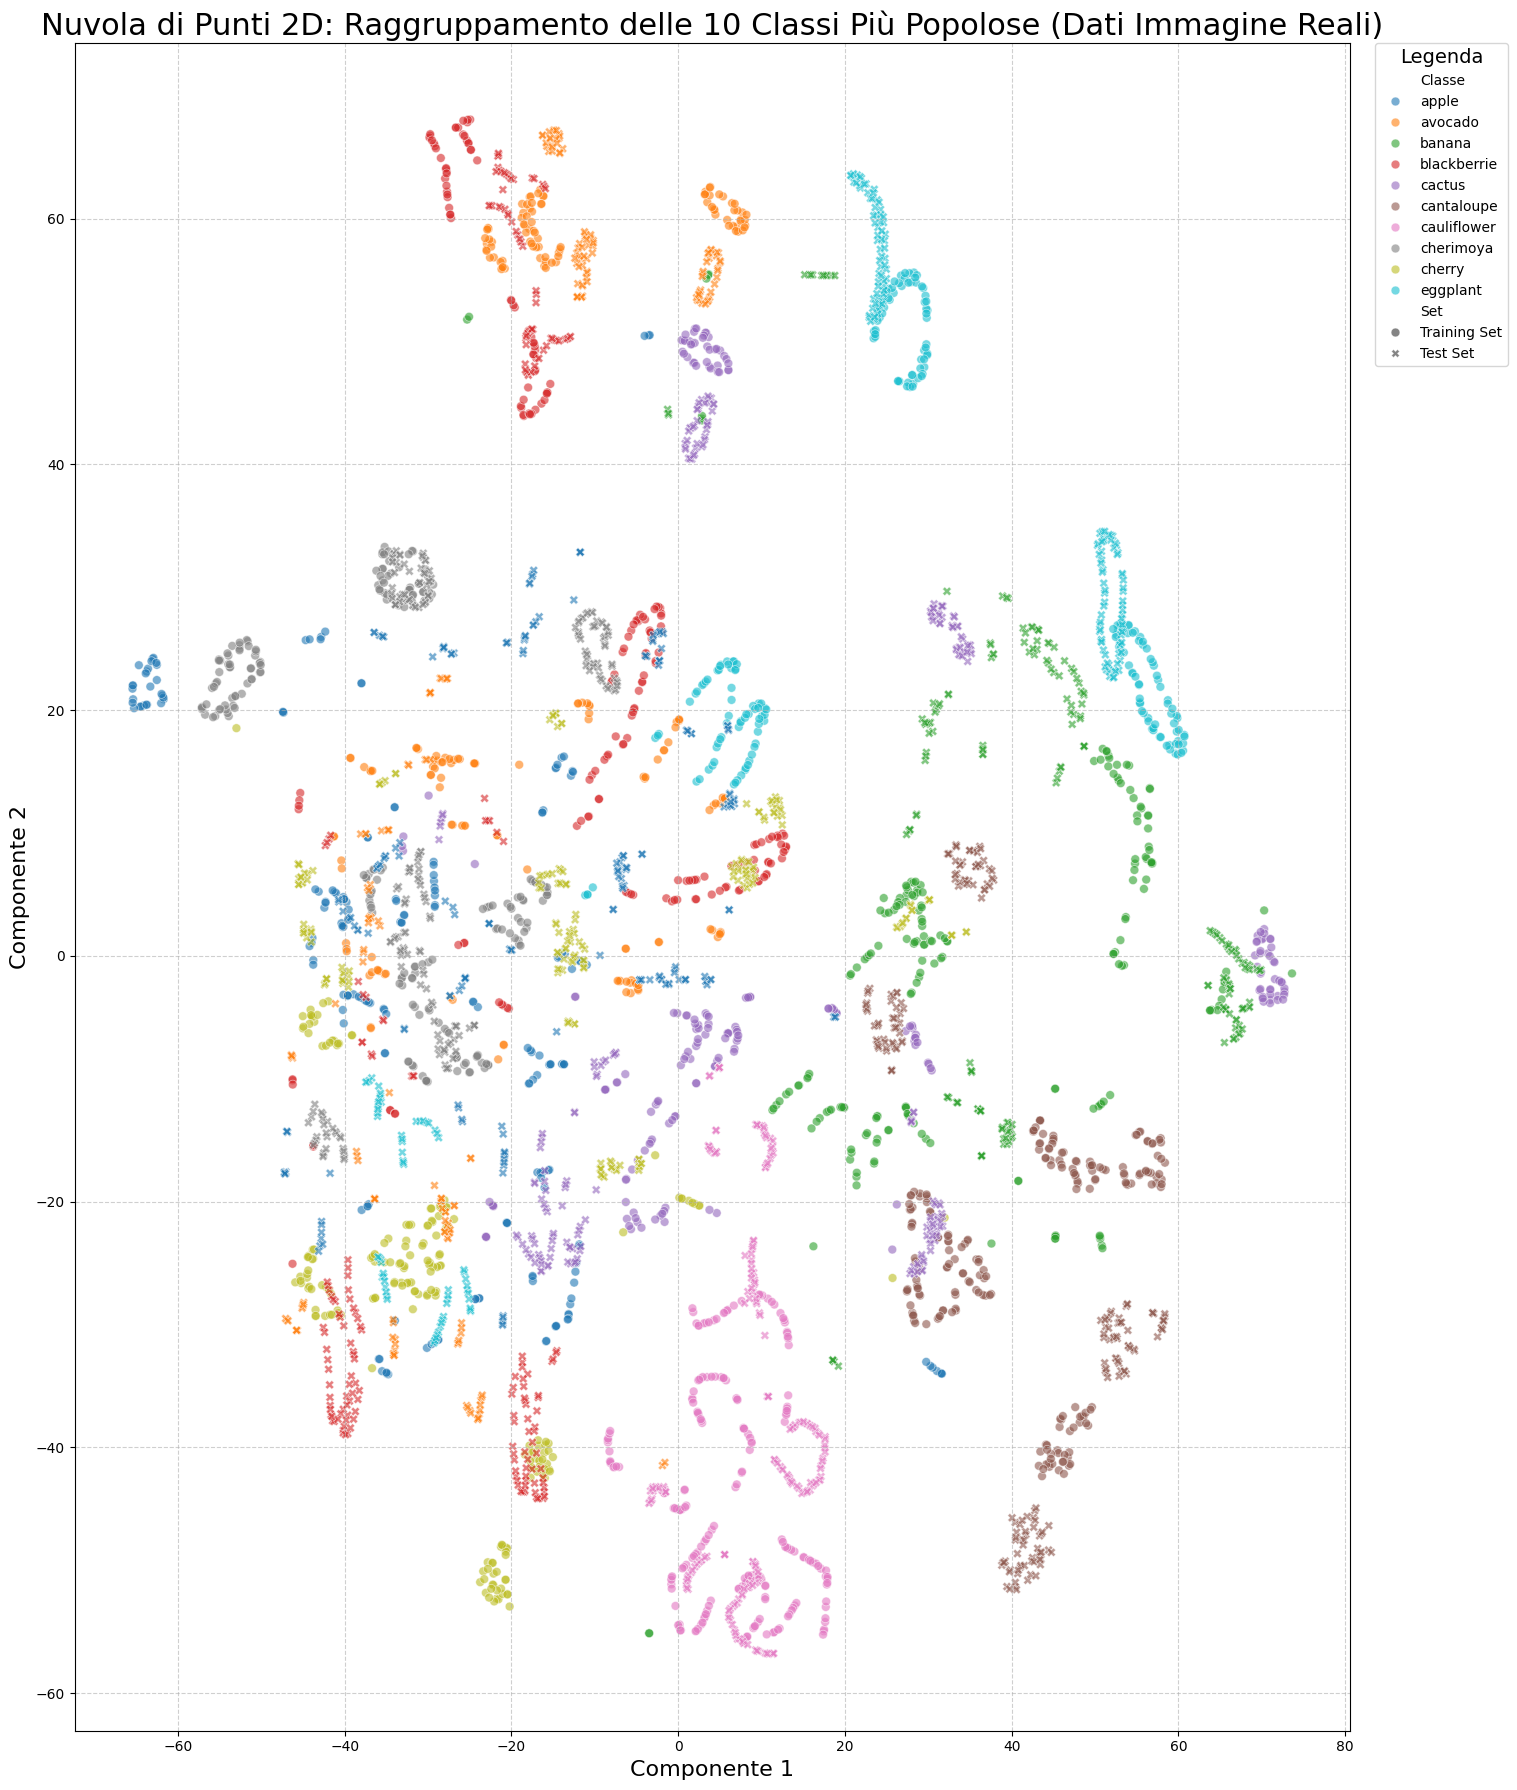

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings

# Silenziamo gli avvisi
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Parametri di Configurazione
MAX_SAMPLES_PER_CLASS_FOR_TSNE = 200

print(f"Max campioni per classe per t-SNE: {MAX_SAMPLES_PER_CLASS_FOR_TSNE}")
print("-" * 50)

print(f"DataFrame di training (feature appiattite) fornito: {len(df_flattened_features_train)} immagini.")
print(f"DataFrame di test (feature appiattite) fornito: {len(df_flattened_features_test)} immagini.")
print("-" * 50)


# 4.1. Determiniamo le 10 Classi Più Popolose dai Dati Forniti
print("Determino le 10 classi più popolose dai DataFrame di feature forniti...")
# Combiniamo temporaneamente le etichette da entrambi i DataFrames per contare la frequenza complessiva
all_labels_combined = pd.concat([df_flattened_features_train['labels'], df_flattened_features_test['labels']], axis=0)
all_labels_counts = all_labels_combined.value_counts().reset_index()
all_labels_counts.columns = ['Classe', 'Total_Images']
df_all_counts_sorted = all_labels_counts.sort_values(by='Total_Images', ascending=False)
top_10_classes = df_all_counts_sorted.head(10)['Classe'].tolist()

print(f"Le 10 classi più popolose sono: {top_10_classes}")
print("-" * 50)


# 4.2. Definiamo la funzione per filtrare e campionare i DataFrame per le Top 10 Classi per t-SNE
def filter_and_sample_dataframe(dataframe, desired_classes_list, max_samples_limit):
    print(f"Filtrando e campionando {len(dataframe)} campioni per le top 10 classi...")
    df_filtered = dataframe[dataframe['labels'].isin(desired_classes_list)].copy()

    sampled_data_list = []
    for cls in df_filtered['labels'].unique():
        class_df = df_filtered[df_filtered['labels'] == cls]
        if len(class_df) > max_samples_limit:
            # random_state per riproducibilità del campionamento
            sampled_data_list.append(class_df.sample(max_samples_limit, random_state=42))
        else:
            sampled_data_list.append(class_df)

    if not sampled_data_list: # Gestisci il caso in cui sampled_data_list sia vuota
        return pd.DataFrame(columns=dataframe.columns)

    return pd.concat(sampled_data_list).reset_index(drop=True)

df_tsne_input_train = filter_and_sample_dataframe(df_flattened_features_train, top_10_classes, MAX_SAMPLES_PER_CLASS_FOR_TSNE)
df_tsne_input_test = filter_and_sample_dataframe(df_flattened_features_test, top_10_classes, MAX_SAMPLES_PER_CLASS_FOR_TSNE)

print(f"\nDataFrame di training (filtrato e campionato per t-SNE): {len(df_tsne_input_train)} immagini.")
print(f"DataFrame di test (filtrato e campionato per t-SNE): {len(df_tsne_input_test)} immagini.")
print("-" * 50)


# 4.3. Definiamo la funzione per Applicare t-SNE a un DataFrame di Feature Appiattite
def apply_tsne_to_flattened_features(dataframe_features, feature_column, label_column, n_components=2):
    print(f"Applicazione di t-SNE a {len(dataframe_features)} campioni...")

    if dataframe_features.empty:
        print("Il DataFrame di input per t-SNE è vuoto. Restituzione DataFrame vuoto.")
        return pd.DataFrame(columns=[f'Componente {i+1}' for i in range(n_components)] + ['Classe'])

    X = np.vstack(dataframe_features[feature_column].values)
    y = dataframe_features[label_column].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tsne = TSNE(n_components=n_components, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)
    tsne_results = tsne.fit_transform(X_scaled)
    print("t-SNE completato.")

    column_names = [f'Componente {i+1}' for i in range(n_components)]
    tsne_df = pd.DataFrame(tsne_results, columns=column_names)
    tsne_df['Classe'] = y
    tsne_df['Classe'] = pd.Categorical(tsne_df['Classe'], categories=tsne_df['Classe'].unique(), ordered=False)

    print(f"DataFrame ridotto creato con shape: {tsne_df.shape}")
    return tsne_df


# 4.4. Esecuzione dell'Applicazione di t-SNE ai Dati Filtrati e Appiattiti
print("Inizio applicazione t-SNE ai dati di training e test (feature appiattite e filtrate)...")

df_tsne_train = apply_tsne_to_flattened_features(df_tsne_input_train, 'features', 'labels')
df_tsne_test = apply_tsne_to_flattened_features(df_tsne_input_test, 'features', 'labels')

print("\nDataFrame con dimensionalità ridotta per il plotting (solo 10 classi più popolose):")
print("df_tsne_train (prime 5 righe):\n", df_tsne_train.head())
print("\ndf_tsne_test (prime 5 righe):\n", df_tsne_test.head())
print("-" * 50)

# --- df_tsne_train e df_tsne_test sono ora pronti per il plotting ---

if df_tsne_train.empty and df_tsne_test.empty:
    print("Impossibile generare il grafico: nessun dato disponibile dopo il filtraggio e t-SNE.")
else:
    df_tsne_train['Set'] = 'Training Set'
    df_tsne_test['Set'] = 'Test Set'
    df_combined_tsne = pd.concat([df_tsne_train, df_tsne_test], ignore_index=True)

    plt.figure(figsize=(18, 18))
    ax = sns.scatterplot(
        x='Componente 1',
        y='Componente 2',
        hue='Classe',
        style='Set',
        data=df_combined_tsne,
        palette='tab10',
        legend='full',
        alpha=0.6,
        s=40
    )
    plt.title('Nuvola di Punti 2D: Raggruppamento delle 10 Classi Più Popolose (Dati Immagine Reali)', fontsize=22)
    plt.xlabel('Componente 1', fontsize=16)
    plt.ylabel('Componente 2', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Legenda', title_fontsize='14', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# **2.2	Nuvola di punti 3D**
Visto i pattern evidenziati dalle visualizzazioni precedenti, alcuni riconoscibili ma con apparenti outlier ed “invasioni” tra i diversi gruppi, proviamo ad aggiungere una dimensione per esplorare nuovamente i dati. Il codice seguente ci permetterà la visualizzazione dei dati in 3 dimensioni con la possibilità di ruotare e zoomare nel grafico mostrato.

Max campioni per classe per t-SNE: 200
--------------------------------------------------
Caricamento dati dal dataset aggregato in: /content/drive/MyDrive/FruitDLProj/frutti/aggregati
Immagini ridimensionate a: 64x64 prima di appiattire.
Max campioni per classe: 200 per ridurre il carico di t-SNE.
--------------------------------------------------
Caricamento percorsi da: /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Training
Caricamento percorsi da: /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Test

DataFrame di training (percorsi) caricato: 14751 immagini.
DataFrame di test (percorsi) caricato: 12673 immagini.
--------------------------------------------------
Caricamento e pre-processing di 14751 immagini per ottenere feature appiattite...
Caricamento e pre-processing di 12673 immagini per ottenere feature appiattite...

DataFrame di training (feature appiattite) creato: 14751 immagini.
Dimensione feature (per immagine): 12288
DataFrame di test (feature appiattite) cre

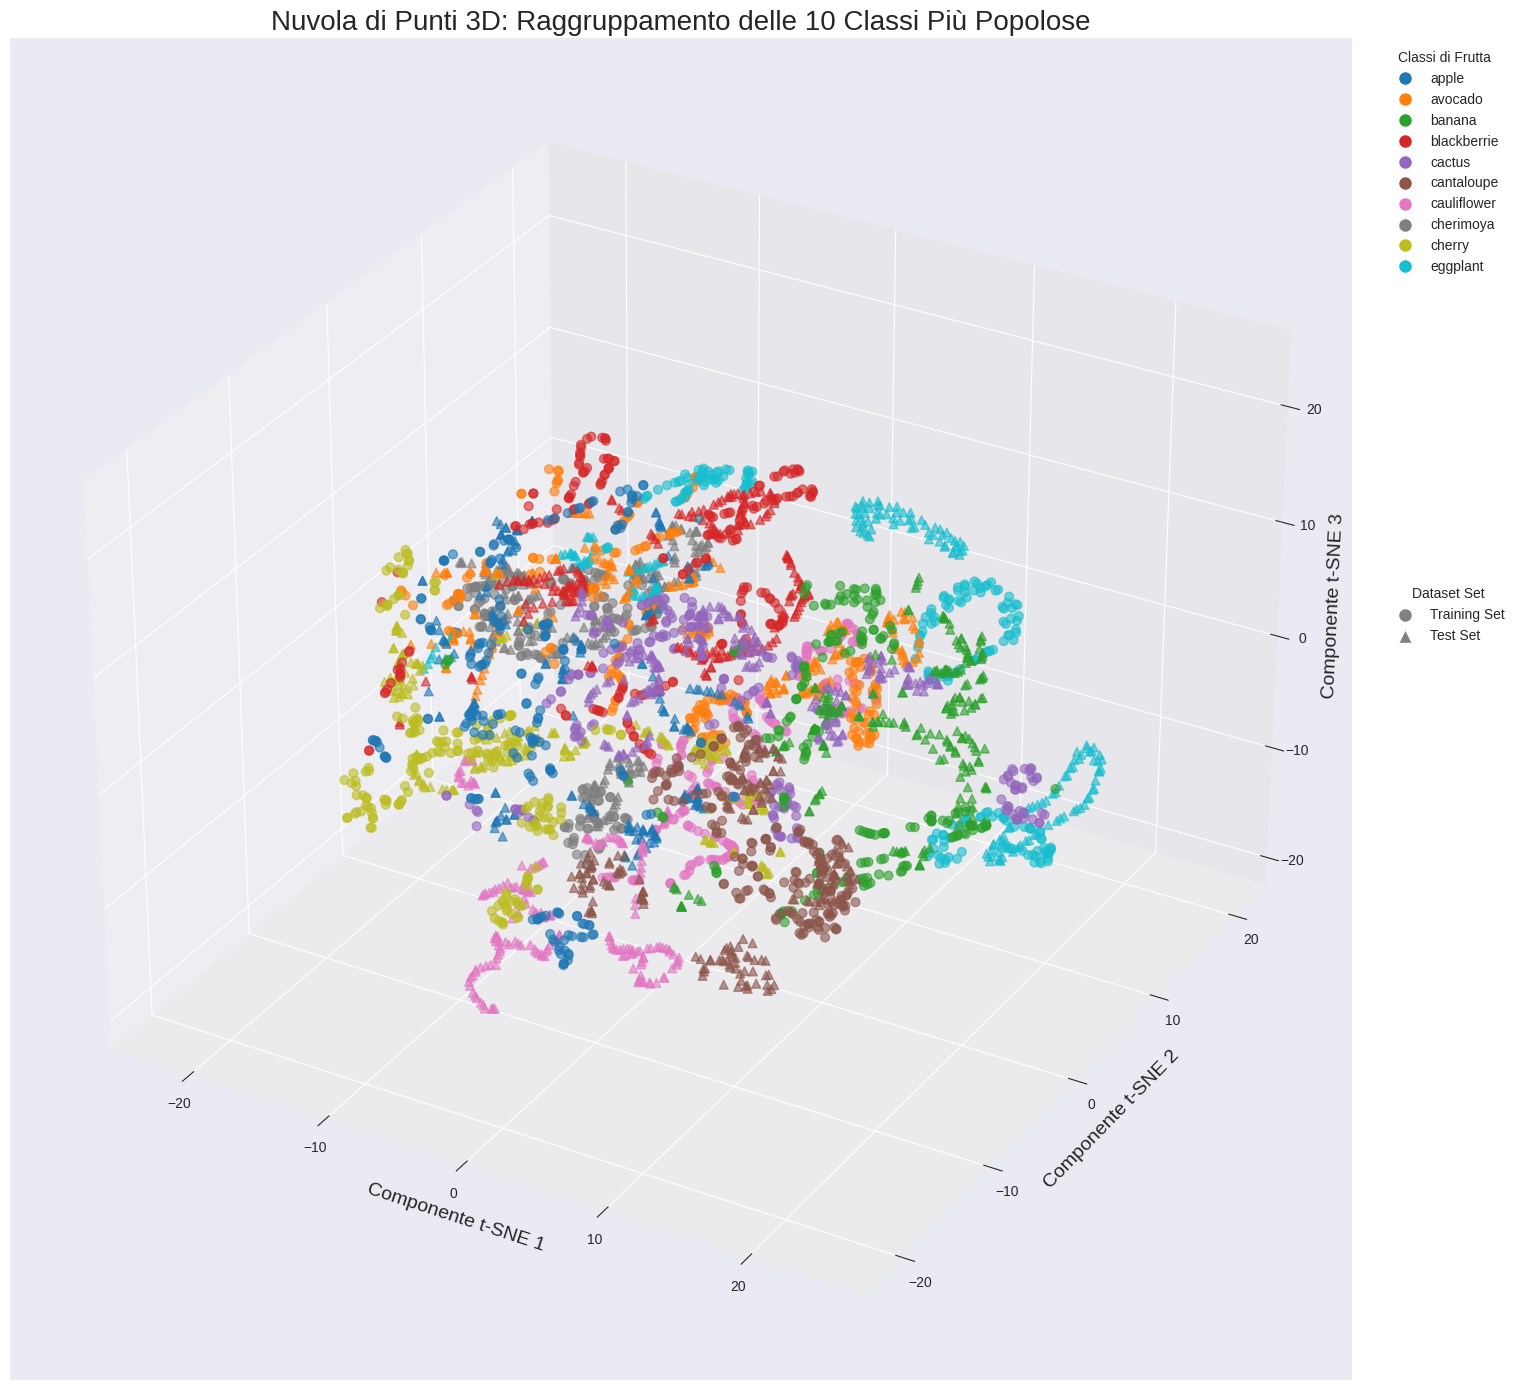


Processo di riduzione dimensionalità 3D e plotting completato.


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Necessario per la proiezione 3D
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
import random
from PIL import Image # Necessaria per caricare le immagini

# Silenziare gli avvisi
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# nel caso si presenti l'avviso OpenBLAS è possibile operare abilitando le variabili d'ambiente seguenti:
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Parametri di Configurazione
MAX_SAMPLES_PER_CLASS_FOR_TSNE = 200 # Campiona fino a 200 immagini per ogni classe per t-SNE.
IMAGE_SIZE_FOR_TSNE = (64, 64)       # Larghezza, Altezza (es. 64x64 pixel).

aggregated_dataset_root = '/content/drive/MyDrive/FruitDLProj/frutti/aggregati'
train_dir_aggregated = os.path.join(aggregated_dataset_root, 'Training')
test_dir_aggregated = os.path.join(aggregated_dataset_root, 'Test')

print(f"Max campioni per classe per t-SNE: {MAX_SAMPLES_PER_CLASS_FOR_TSNE}")
print("-" * 50)


print(f"Caricamento dati dal dataset aggregato in: {aggregated_dataset_root}")
print(f"Immagini ridimensionate a: {IMAGE_SIZE_FOR_TSNE[0]}x{IMAGE_SIZE_FOR_TSNE[1]} prima di appiattire.")
print(f"Max campioni per classe: {MAX_SAMPLES_PER_CLASS_FOR_TSNE} per ridurre il carico di t-SNE.")
print("-" * 50)

# 5.1. Funzione per caricare i percorsi delle immagini e le etichette dalle cartelle aggregate.
def load_aggregated_dataset_to_dataframe(base_dir, max_samples_limit=None):
    filepaths = []
    labels = []

    print(f"Caricamento percorsi da: {base_dir}")
    for aggregated_class_folder in os.listdir(base_dir):
        class_path = os.path.join(base_dir, aggregated_class_folder)
        if os.path.isdir(class_path):
            img_names = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(img_names)

            if max_samples_limit and len(img_names) > max_samples_limit:
                img_names = random.sample(img_names, max_samples_limit)

            for img_name in img_names:
                filepaths.append(os.path.join(class_path, img_name))
                labels.append(aggregated_class_folder.lower())

    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# 5.2. Funzione per caricare, pre-processare e appiattire le immagini in un DataFrame di feature.
def load_and_flatten_images(dataframe_paths, image_size):
    print(f"Caricamento e pre-processing di {len(dataframe_paths)} immagini per ottenere feature appiattite...")
    features_list = []
    labels_list = []

    for index, row in dataframe_paths.iterrows():
        try:
            img_path = row['filepaths']
            label = row['labels']
            if not os.path.exists(img_path):
                print(f"AVVISO: Immagine non trovata a '{img_path}'. Saltata.")
                continue

            img = Image.open(img_path).convert('RGB')
            img = img.resize(image_size)
            img_array = np.array(img) / 255.0
            features_list.append(img_array.flatten())
            labels_list.append(label)
        except Exception as e:
            print(f"ATTENZIONE: Saltata immagine '{img_path}' a causa di errore: {e}")

    return pd.DataFrame({'features': features_list, 'labels': labels_list})

# 5.3. Funzione per applicare t-SNE a 3 componenti a un DataFrame di feature appiattite.
def apply_tsne_to_flattened_features_3d(dataframe_features, feature_column, label_column, n_components=3):
    print(f"Applicazione di t-SNE 3D a {len(dataframe_features)} campioni...")

    if dataframe_features.empty:
        print("Il DataFrame di input per t-SNE è vuoto. Restituzione DataFrame vuoto.")
        return pd.DataFrame(columns=[f'Componente {i+1}' for i in range(n_components)] + ['Classe'])

    X = np.vstack(dataframe_features[feature_column].values)
    y = dataframe_features[label_column].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tsne = TSNE(n_components=n_components, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)
    tsne_results = tsne.fit_transform(X_scaled)
    print("t-SNE 3D completato.")

    column_names = [f'Componente {i+1}' for i in range(n_components)]
    tsne_df = pd.DataFrame(tsne_results, columns=column_names)
    tsne_df['Classe'] = y
    tsne_df['Classe'] = pd.Categorical(tsne_df['Classe'], categories=tsne_df['Classe'].unique(), ordered=False)

    print(f"DataFrame ridotto creato con shape: {tsne_df.shape}")
    return tsne_df

# 5.4. Funzione per filtrare e campionare i DataFrame per le top 10 classi per t-SNE.
def filter_and_sample_dataframe(dataframe, desired_classes_list, max_samples_limit):
    print(f"Filtrando e campionando {len(dataframe)} campioni per le top 10 classi...")
    df_filtered = dataframe[dataframe['labels'].isin(desired_classes_list)].copy()

    sampled_data_list = []
    for cls in df_filtered['labels'].unique():
        class_df = df_filtered[df_filtered['labels'] == cls]
        if len(class_df) > max_samples_limit:
            sampled_data_list.append(class_df.sample(max_samples_limit, random_state=42))
        else:
            sampled_data_list.append(class_df)

    if not sampled_data_list:
        return pd.DataFrame(columns=dataframe.columns)

    return pd.concat(sampled_data_list).reset_index(drop=True)

# 5.5. Caricamento iniziale dei percorsi delle immagini
df_train_paths_initial = load_aggregated_dataset_to_dataframe(train_dir_aggregated, MAX_SAMPLES_PER_CLASS_FOR_TSNE)
df_test_paths_initial = load_aggregated_dataset_to_dataframe(test_dir_aggregated, MAX_SAMPLES_PER_CLASS_FOR_TSNE)

print(f"\nDataFrame di training (percorsi) caricato: {len(df_train_paths_initial)} immagini.")
print(f"DataFrame di test (percorsi) caricato: {len(df_test_paths_initial)} immagini.")
print("-" * 50)

# 5.6. Convertiamo i percorsi in feature appiattite
df_flattened_features_train = load_and_flatten_images(df_train_paths_initial, IMAGE_SIZE_FOR_TSNE)
df_flattened_features_test = load_and_flatten_images(df_test_paths_initial, IMAGE_SIZE_FOR_TSNE)

print(f"\nDataFrame di training (feature appiattite) creato: {len(df_flattened_features_train)} immagini.")
if not df_flattened_features_train.empty:
    print(f"Dimensione feature (per immagine): {df_flattened_features_train['features'].iloc[0].shape[0]}")
print(f"DataFrame di test (feature appiattite) creato: {len(df_flattened_features_test)} immagini.")
if not df_flattened_features_test.empty:
    print(f"Dimensione feature (per immagine): {df_flattened_features_test['features'].iloc[0].shape[0]}")
print("-" * 50)


# 5.7. Determiniamo le 10 Classi Più Popolose dai Dati
print("Determino le 10 classi più popolose dai DataFrame di feature forniti...")
all_labels_combined = pd.concat([df_flattened_features_train['labels'], df_flattened_features_test['labels']], axis=0)
all_labels_counts = all_labels_combined.value_counts().reset_index()
all_labels_counts.columns = ['Classe', 'Total_Images']
df_all_counts_sorted = all_labels_counts.sort_values(by='Total_Images', ascending=False)
top_10_classes = df_all_counts_sorted.head(10)['Classe'].tolist()

print(f"Le 10 classi più popolose sono: {top_10_classes}")
print("-" * 50)


# 5.8. Filtriamo e Campioniamo i DataFrame per le Top 10 Classi per t-SNE
df_tsne_input_train = filter_and_sample_dataframe(df_flattened_features_train, top_10_classes, MAX_SAMPLES_PER_CLASS_FOR_TSNE)
df_tsne_input_test = filter_and_sample_dataframe(df_flattened_features_test, top_10_classes, MAX_SAMPLES_PER_CLASS_FOR_TSNE)

print(f"\nDataFrame di training (filtrato e campionamento per t-SNE): {len(df_tsne_input_train)} immagini.")
print(f"DataFrame di test (filtrato e campionamento per t-SNE): {len(df_tsne_input_test)} immagini.")
print("-" * 50)


# 5.9. Esecuzione dell'Applicazione di t-SNE a 3D
print("Inizio applicazione t-SNE 3D ai dati di training e test (feature appiattite e filtrate)...")

df_tsne_train_3d = apply_tsne_to_flattened_features_3d(df_tsne_input_train, 'features', 'labels')
df_tsne_test_3d = apply_tsne_to_flattened_features_3d(df_tsne_input_test, 'features', 'labels')

print("\nDataFrame con dimensionalità ridotta per il plotting 3D (solo 10 classi più popolose):")
print("df_tsne_train_3d (prime 5 righe):\n", df_tsne_train_3d.head())
print("df_tsne_test_3d (prime 5 righe):\n", df_tsne_test_3d.head())
print("-" * 50)

# 5.10. Codice per il Plotting della Nuvola di Punti 3D Interattiva

if df_tsne_train_3d.empty and df_tsne_test_3d.empty:
    print("Impossibile generare il grafico 3D: nessun dato disponibile dopo il filtraggio e t-SNE.")
else:
    df_tsne_train_3d['Set'] = 'Training Set'
    df_tsne_test_3d['Set'] = 'Test Set'
    df_combined_tsne_3d = pd.concat([df_tsne_train_3d, df_tsne_test_3d], ignore_index=True)

    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(18, 14))
    ax = fig.add_subplot(111, projection='3d')

    unique_classes_combined = df_combined_tsne_3d['Classe'].unique()
    colors_palette = sns.color_palette('tab10', n_colors=len(unique_classes_combined))
    class_color_map = {cls: colors_palette[i] for i, cls in enumerate(unique_classes_combined)}

    for class_name in unique_classes_combined:
        for set_type in df_combined_tsne_3d['Set'].unique():
            subset = df_combined_tsne_3d[(df_combined_tsne_3d['Classe'] == class_name) & (df_combined_tsne_3d['Set'] == set_type)]

            marker = 'o' if set_type == 'Training Set' else '^'

            ax.scatter(
                subset['Componente 1'],
                subset['Componente 2'],
                subset['Componente 3'],
                c=[class_color_map[class_name]],
                marker=marker,
                s=40,
                alpha=0.6,
            )

    ax.set_title('Nuvola di Punti 3D: Raggruppamento delle 10 Classi Più Popolose', fontsize=20)
    ax.set_xlabel('Componente t-SNE 1', fontsize=14)
    ax.set_ylabel('Componente t-SNE 2', fontsize=14)
    ax.set_zlabel('Componente t-SNE 3', fontsize=14)

    from matplotlib.lines import Line2D
    legend_elements_classes = []
    for cls in unique_classes_combined:
        legend_elements_classes.append(Line2D([0], [0], marker='o', color='w', label=cls,
                                             markerfacecolor=class_color_map[cls], markersize=10))

    legend_elements_sets = [
        Line2D([0], [0], marker='o', color='w', label='Training Set', markerfacecolor='gray', markersize=10),
        Line2D([0], [0], marker='^', color='w', label='Test Set', markerfacecolor='gray', markersize=10)
    ]

    legend1 = ax.legend(handles=legend_elements_classes, title='Classi di Frutta', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1, fontsize=10)
    ax.add_artist(legend1)
    legend2 = ax.legend(handles=legend_elements_sets, title='Dataset Set', bbox_to_anchor=(1.02, 0.6), loc='upper left', ncol=1, fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()

print("\nProcesso di riduzione dimensionalità 3D e plotting completato.")

# **3	Data Augmentation**
Le CNN sono particolarmente adatte per elaborare immagini con vari filtri (kernel) che vengono applicati a scorrimento alle sezioni di queste rendendole robuste alla traslazione del contenuto, riconoscendo i diversi pattern a prescindere dalla loro posizione. Lo stesso discorso non si può fare per rotazioni, distorsioni e noise, per cui per rendere il modello più robusto si procede alla “data augmentation” del dataset di training in modo che contenga anche le versioni alterate delle immagini.
Sfruttando Keras con ImageDataGenerator procediamo a creare in tempo reale delle varianti delle immagini al fine di estendere il dataset fornito per l'addestramento della nostra IA.
Nel codice seguente useremo ImageDataGenerator per le seguenti trasformazioni:
*	rescale=1./255: Normalizza i valori dei pixel da [0, 255] a [0, 1];
*	rotation_range:Applica leggere rotazioni;
*	shear_range: Applica delle deformazioni;
*	zoom_range: Zoom in/out sulle immagini;
*	horizontal_flip=True: Effettua il ribaltamento orizzontale delle immagini;
*	fill_mode='nearest': Indica la modalità con cui riempire i pixel creati dalle trasformazioni.
Con le immagini generate usiamo flow_from_directory per caricare le immagini e assegnare le etichette. Specifichiamo il target_size (ad esempio (100, 100)), batch_size, class_mode='categorical'.


Determino le 10 classi più popolose direttamente dalle cartelle aggregate...
Le 10 classi più popolose determinate dinamicamente sono: ['tomato', 'apple', 'cherry', 'pear', 'nut', 'grape', 'banana', 'avocado', 'cucumber', 'quince']
--------------------------------------------------
Caricamento percorsi filtrati da: /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Training
Caricamento percorsi filtrati da: /content/drive/MyDrive/FruitDLProj/frutti/aggregati/Test
DataFrame di training (percorsi) caricato con 13007 immagini.
DataFrame di test (percorsi) caricato con 6831 immagini.
--------------------------------------------------
Creazione del generatore di immagini per il training set con Data Augmentation...
Found 13007 validated image filenames belonging to 10 classes.

Generatore per il training set configurato con successo!
Nomi delle classi e loro indici: {'tomato': 0, 'apple': 1, 'cherry': 2, 'pear': 3, 'nut': 4, 'grape': 5, 'banana': 6, 'avocado': 7, 'cucumber': 8, 'quince': 9

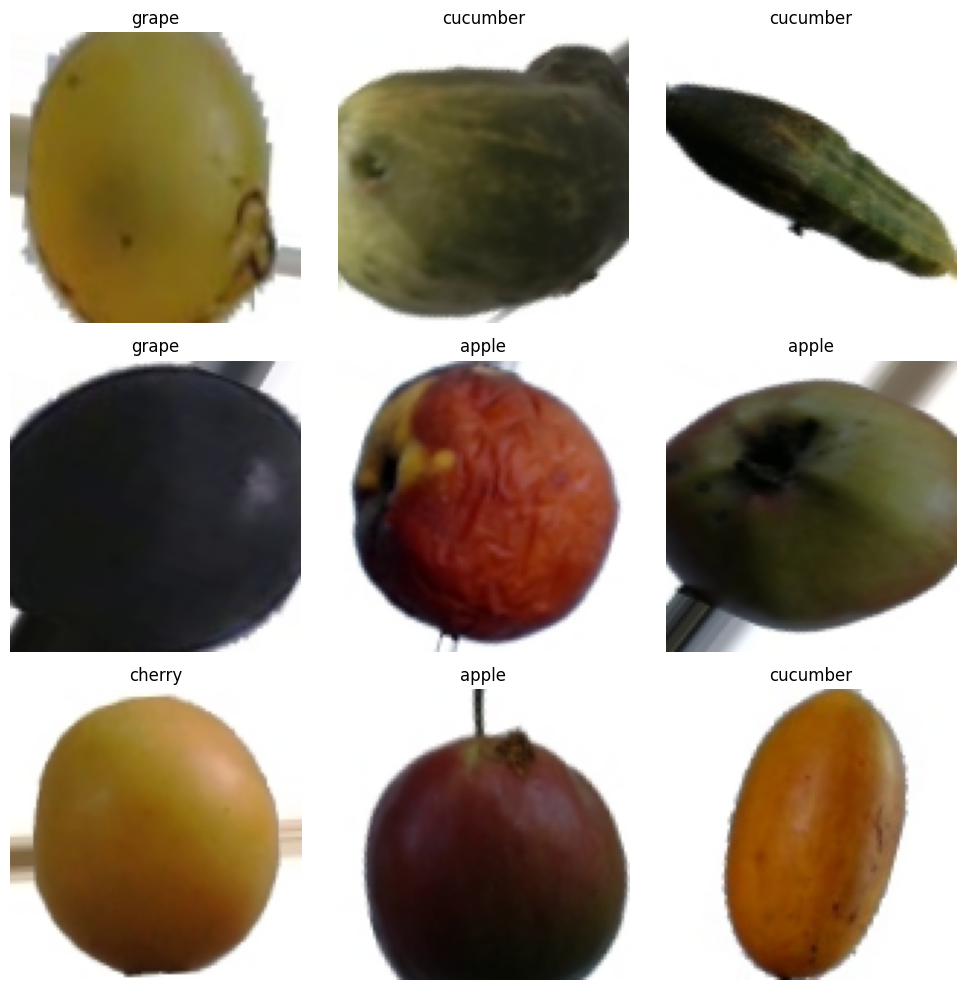


Processo di preparazione dei generatori di dati completato!


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd # Necessario per flow_from_dataframe se non hai df_train/df_test già pronti

# Configurazione dei Percorsi e Parametri
# Questi percorsi devono puntare al tuo dataset aggregato creato in precedenza.
aggregated_dataset_root = '/content/drive/MyDrive/FruitDLProj/frutti/aggregati'
train_dir_aggregated = os.path.join(aggregated_dataset_root, 'Training')
test_dir_aggregated = os.path.join(aggregated_dataset_root, 'Test')

# Dimensioni target per le immagini della CNN
TARGET_SIZE = (100, 100) # (Altezza, Larghezza)
BATCH_SIZE = 32          # Numero di immagini per batch

# Determinare le 10 Classi Più Popolose dal Dataset Aggregato
print("Determino le 10 classi più popolose direttamente dalle cartelle aggregate...")
all_aggregated_labels_counts = {}

# Conta le immagini per ogni classe nelle cartelle di training aggregate
if os.path.exists(train_dir_aggregated):
    for class_folder in os.listdir(train_dir_aggregated):
        class_path = os.path.join(train_dir_aggregated, class_folder)
        if os.path.isdir(class_path):
            # Il nome della cartella è già la classe aggregata (es. 'apple', 'banana')
            all_aggregated_labels_counts[class_folder.lower()] = all_aggregated_labels_counts.get(class_folder.lower(), 0) + len(os.listdir(class_path))
else:
    print(f"ATTENZIONE: Directory di training aggregata non trovata: {train_dir_aggregated}. Impossibile determinare classi popolose.")

# Conta le immagini per ogni classe nelle cartelle di test aggregate
if os.path.exists(test_dir_aggregated):
    for class_folder in os.listdir(test_dir_aggregated):
        class_path = os.path.join(test_dir_aggregated, class_folder)
        if os.path.isdir(class_path):
            all_aggregated_labels_counts[class_folder.lower()] = all_aggregated_labels_counts.get(class_folder.lower(), 0) + len(os.listdir(class_path))
else:
    print(f"ATTENZIONE: Directory di test aggregata non trovata: {test_dir_aggregated}. Impossibile determinare classi popolose.")


# Converte in DataFrame, ordina e seleziona le top 10
df_all_counts = pd.DataFrame(all_aggregated_labels_counts.items(), columns=['Classe', 'Total_Images'])
df_all_counts_sorted = df_all_counts.sort_values(by='Total_Images', ascending=False)
TOP_10_CLASSES_DYNAMIC = df_all_counts_sorted.head(10)['Classe'].tolist()

print(f"Le 10 classi più popolose determinate dinamicamente sono: {TOP_10_CLASSES_DYNAMIC}")
print("-" * 50)

# Creazione dei DataFrame con percorsi e etichette per flow_from_dataframe
# Funzione per caricare i percorsi delle immagini e le etichette in un DataFrame
# (filtra le classi TOP 10)
def load_paths_for_top_classes(base_dir, desired_classes_list):
    filepaths = []
    labels = []

    print(f"Caricamento percorsi filtrati da: {base_dir}")
    for class_folder in os.listdir(base_dir): # Itera sulle cartelle di classe già aggregate
        if class_folder.lower() in desired_classes_list:
            class_path = os.path.join(base_dir, class_folder)
            if os.path.isdir(class_path):
                img_names = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

                # Aggiunge tutti i percorsi e le etichette per classe
                for img_name in img_names:
                    filepaths.append(os.path.join(class_path, img_name))
                    labels.append(class_folder.lower()) # L'etichetta è il nome della cartella

    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Caricamento dei DataFrame con i percorsi dei file e le etichette aggregate (filtrati per le top 10)
df_train = load_paths_for_top_classes(train_dir_aggregated, set(TOP_10_CLASSES_DYNAMIC))
df_test = load_paths_for_top_classes(test_dir_aggregated, set(TOP_10_CLASSES_DYNAMIC))

print(f"DataFrame di training (percorsi) caricato con {len(df_train)} immagini.")
print(f"DataFrame di test (percorsi) caricato con {len(df_test)} immagini.")
print("-" * 50)


# 6.1. Creazione di ImageDataGenerator per il Training Set con Data Augmentation ---
print("Creazione del generatore di immagini per il training set con Data Augmentation...")
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalizza i pixel da [0, 255] a [0, 1]
    rotation_range=40,              # Applica leggere rotazioni casuali fino a 40 gradi
    shear_range=0.2,                # Applica delle deformazioni di "taglio" (shear transformation)
    zoom_range=0.2,                 # Applica zoom casuale in/out (tra 80% e 120% della dimensione originale)
    horizontal_flip=True,           # Effettua il ribaltamento orizzontale casuale delle immagini
    fill_mode='nearest'             # Indica la modalità con cui riempire i pixel nuovi creati dalle trasformazioni
)

# Utilizza flow_from_dataframe per caricare le immagini e assegnare le etichette
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,             # Il DataFrame contenente percorsi e etichette
    x_col='filepaths',              # Colonna del DataFrame con i percorsi delle immagini
    y_col='labels',                 # Colonna del DataFrame con le etichette di classe
    target_size=TARGET_SIZE,        # Ridimensiona tutte le immagini a questa dimensione
    batch_size=BATCH_SIZE,          # Numero di immagini da restituire per ogni batch
    class_mode='categorical',       # Le etichette saranno in formato one-hot encoded
    classes=TOP_10_CLASSES_DYNAMIC, # Utilizza le classi determinate dinamicamente
    shuffle=True                    # Mescola l'ordine delle immagini per ogni epoca
)

print("\nGeneratore per il training set configurato con successo!")
print(f"Nomi delle classi e loro indici: {train_generator.class_indices}")
print("-" * 50)

# 6.2. Creazione del generatore per il Test/Validation Set (SENZA data augmentation) ---
print("Creazione del generatore di immagini per il test/validation set (solo rescale)...")
test_datagen = ImageDataGenerator(rescale=1./255) # Solo normalizzazione

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,              # Il DataFrame contenente percorsi e etichette del test set
    x_col='filepaths',
    y_col='labels',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=TOP_10_CLASSES_DYNAMIC, # Utilizza le classi determinate dinamicamente
    shuffle=False                   # Non mescolare il test set per avere risultati riproducibili
)

print("\nGeneratore per il test set configurato con successo!")
print("-" * 50)


# 6.3. Visualizza alcuni batch di immagini generate
# Questo blocco è utile per verificare che le trasformazioni funzionino come previsto
import matplotlib.pyplot as plt
print("\nVisualizzazione di alcune immagini trasformate (può richiedere qualche secondo)...")
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(min(9, BATCH_SIZE)): # Visualizza fino a 9 immagini dal primo batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        # Per decodificare la label one-hot e mostrare il nome della classe
        current_label_index = tf.argmax(labels[i]).numpy()
        current_label_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(current_label_index)]
        plt.title(current_label_name)
        plt.axis("off")
    break # Interrompi dopo il primo batch
plt.tight_layout()
plt.show()

print("\nProcesso di preparazione dei generatori di dati completato!")

# **4	Definizione del modello**
Ora che abbiamo preparato i dati per addestrare il modello siamo pronti a definirne l’architettura.
Come detto in principio, per la natura del compito, l’analisi di immagini e la loro classificazione, abbiamo scelto una Convolutional Neural Network che, applicando diversi filtri (kernel) a delle porzioni di immagine fino a scorrerla tutta, scopre tramite questi delle rappresentazioni via via più complesse (Da quelle di basso livello a quelle più ad alto livello) fino a poter comprendere il contenuto dell’immagine e classificarla.
Utilizzando l’API sequenziale di Keras metterem, appunto, in sequenza, i diversi hidden layer della nostra CNN che saranno così definiti:
*	Nel primo layer abbiamo un blocco convoluzionale (Conv2D) che esplora le immagini con 32 kernel 3x3 e attivazione ReLU (per evitare il vanishing gradient). Questo è seguito da un layer di Max Pooling (2x2) per ridurre la dimensionalità e la complessità computazionale delle feature map;
*	Un secondo layer con blocco convoluzionale con 64 kernel e Max pooling;
*	Un terzo layer con blocco convoluzionale con 128 kernel e Max pooling;
*	Un quarto layer con blocco convoluzionale con 256 kernel e Max pooling;
*	Un quinto layer di Dropout che disattiva casualmente una percentuale di neuroni in ogni passo di addestramento forzando i neuroni ad apprendere percorsi alternativi e a ridurre le co-dipendenze. Grazie a questo strato otterremo un modello più robusto che, usando tutti i neuroni disponibili durante la predizione, sarà in grado di sopperire ad eventuali malfunzionamenti di alcuni di questi e sarà inoltre meno soggetto all'overfitting;
*	Un sesto layer di Flatten che appiattisce l'output degli strati convoluzionali per passarlo agli strati Dense (Converte l'output in 3 dimensioni (altezza, larghezza e filtri) in uno monodimensionale);
*	Un Hidden Layer di tipo Dense strutturato come rete a Percettroni Multistrato con funzione di attivazione ReLU;
*	Un ottavo layer di Dropout;
*	Un nono ed ultimo layer di tipo Dense con numero di neuroni pari al numero di classi da categorizzare che, con funzione di attivazione Softmax, converte gli output grezzi dei neuroni in probabilità che l’immagine analizzata appartenga ad una specifica classe.

Come si può osservare, layer dopo layer, aumentiamo il numero di kernel al fine di catturare pattern sempre più complessi ed astratti mentre il Max pooling 2x2 va a dimezzare la dimensione della feature map dopo ogni livello, occupandoci poi di migliorare la robustezza del modello per malfunzionamenti dei neuroni ed evitare l’overfitting ottenendo alla fine l’elenco delle probabilità che una data immagine appartenga alle varie classi. La probabilità migliore sarà la classificazione restituita dal nostro modello.

**Ottimizzatore**
L'ottimizzatore Adam si presta bene alla nostra esercitazione per l'efficienza computazionale e per la poca necessità di personalizzazione dei parametri, funzionando generalmente bene con le impostazioni di default.
La caratteristica più importante di Adam è la sua capacità di adattare il tasso di apprendimento (learning rate) per ogni singolo peso del modello, non solo per la rete nel suo complesso. Questo significa:
*	Per pesi associati a caratteristiche che variano molto Adam può usare passi più piccoli;
*	Per pesi che variano meno può usare passi più grandi per accelerare la convergenza.

Adam inoltre tiene conto della direzione dei gradienti passati, sfrutta il “Momentum”, per “dare slancio” agli aggiornamenti dei pesi, aiutando l'ottimizzatore a:
*	Superare i "minimi locali";
*	Accelerare l'addestramento quando la direzione del gradiente è coerente.

**Funzione di Loss**
La funzione di Loss CCE (Categorical Cross Entropy) misura quanto una previsione è errata, di quanto questa si discosta dalle Ground Truth (Le etichette fornite).
Cerchiamo di immaginare il funzionamento del nostro modello:
Data un'immagine di mela, il modello produce delle probabilità per le tre classi:
*	Previsione del modello: [0.8, 0.1, 0.1] (80% mela, 10% banana, 10% arancia)
*	Etichetta reale (one-hot): [1.0, 0.0, 0.0] (è una mela)

La CCE calcola una penalità basata su quanto le probabilità previste per le classi sbagliate sono alte, e quanto la probabilità prevista per la classe corretta è bassa.
La formula è: $L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$

Dove $C$ indica il numero delle classi, $y_i$ la ground truth (1 o 0) ed $\hat{y}_i$ la nostra predizione.

*Il logaritmo fa si che quanto più la predizione si avvicina ad 1, tanto più il suo logaritmo si avvicina a 0 risultando meno penalizzante.*


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Parametri del Dataset (Devono essere coerenti con la preparazione dati)
TARGET_SIZE = (100, 100) # (Altezza, Larghezza) delle immagini.
IMAGE_CHANNELS = 3       # 3 per immagini a colori (RGB).

# NUM_CLASSES = len(TOP_10_CLASSES_DYNAMIC)
NUM_CLASSES = 10 # Se le tue classi dinamiche sono sempre 10, puoi mantenerlo fisso qui.

print(f"Dimensioni attese delle immagini in input: {TARGET_SIZE[0]}x{TARGET_SIZE[1]} con {IMAGE_CHANNELS} canali.")
print(f"Numero di classi per l'output: {NUM_CLASSES}")
print("-" * 50)

# 7.1. Architettura di Base della CNN (Implementazione della tua descrizione) ---
print("Definizione dell'architettura della CNN...")

model = Sequential([
    # Primo blocco Convoluzionale e Pooling
    # Esplora immagini con 32 kernel 3x3 e attivazione ReLU, seguito da Max Pooling 2x2.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], IMAGE_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Secondo blocco Convoluzionale e Pooling
    # Esplora con 64 kernel 3x3 e attivazione ReLU, seguito da Max Pooling 2x2.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Terzo blocco Convoluzionale e Pooling
    # Esplora con 128 kernel 3x3 e attivazione ReLU, seguito da Max Pooling 2x2.
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Quarto blocco Convoluzionale e Pooling
    # Esplora con 256 kernel 3x3 e attivazione ReLU, seguito da Max Pooling 2x2.
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Quinto layer: Dropout (dopo gli strati convoluzionali, prima del Flatten)
    tf.keras.layers.Dropout(0.25),

    # Sesto layer: Flatten
    # Appiattisce l'output degli strati convoluzionali per passarlo agli strati Dense.
    tf.keras.layers.Flatten(),

    # Settimo layer: Hidden Layer di tipo Dense
    # Rete a Percettroni Multistrato con 512 neuroni e funzione di attivazione ReLU.
    tf.keras.layers.Dense(512, activation='relu'),

    # Ottavo layer: Dropout
    # Ulteriore Dropout per regolarizzazione prima dell'output finale.
    tf.keras.layers.Dropout(0.5),

    # Nono ed ultimo layer: Strato di output Dense
    # Numero di neuroni pari al numero di classi (NUM_CLASSES) e attivazione Softmax.
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

print("Architettura della CNN definita.")
print("-" * 50)

# 7.2. Compilazione del Modello
print("Compilazione del modello...")
model.compile(
    optimizer='adam',                   # Ottimizzatore Adam (Adaptive Moment Estimation), una scelta robusta ed efficace in grado di adattare il tasso di apprendimento (learning rate) per ogni singolo peso.
    loss='categorical_crossentropy',    # Funzione di perdita per classificazione multi-classe one-hot encoded.
    metrics=['accuracy']                # Metriche da monitorare durante l'addestramento (precisione).
)

print("Modello compilato con successo!")
print("-" * 50)

Dimensioni attese delle immagini in input: 100x100 con 3 canali.
Numero di classi per l'output: 10
--------------------------------------------------
Definizione dell'architettura della CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Architettura della CNN definita.
--------------------------------------------------
Compilazione del modello...
Modello compilato con successo!
--------------------------------------------------


# **4.1 Addestramento del Modello**
In questa fase, alimenteremo il modello che abbiamo definito al passo precedente con i dati di training ed useremo il set di validazione per monitorare le sue prestazioni e prevenire l'overfitting.

La separazione dei train set e test set è fondamentale per vedere che il modello sia in gradi di generalizzare non adattandosi eccessivamente ai dati di addestramento.

Useremo anche i Callbacks per salvare il modello migliore e fermare l'addestramento se non ci sono più miglioramenti, evitando di andare in overfitting.

In [ ]:
# Richiede sempre l'esecuzione dei blocchi 6 e 7 prima di compilare

import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# 8.1. Riepilogo del nuovo Modello
print("Riepilogo dell'architettura del modello (model.summary()):\n")
model.summary()
print("\nDefinizione e compilazione del modello completate!")
print("-" * 50)


# 8.2. Callbacks per l'Addestramento
checkpoint_filepath = '/content/drive/MyDrive/FruitDLProj/models/best_fruit_classifier_model.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=3, # Abbassiamo per raggiungere prima possibile uno stato di operabilità per i test
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [checkpoint_callback, early_stopping_callback]

# 8.3. Addestramento Effettivo del Modello
EPOCHS = 10 # Riduciamo le epoche visto il problema semplificato

print("Inizio addestramento del modello aggregato...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks_list
)

print("\nAddestramento del modello aggregato completato!")
print("-" * 50)

# 8.4. Visualizzazione dell'andamento dell'addestramento
print("Visualizzazione dell'andamento di accuratezza e loss per il modello aggregato...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Aggregated Classes)')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Aggregated Classes)')
plt.xlabel('Epoca')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print("\nAddestramento completato e cronologia visualizzata per le classi aggregate.")

Riepilogo dell'architettura del modello (model.summary()):



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,491,210 (9.50 MB)

 Trainable params: 2,491,210 (9.50 MB)

 Non-trainable params: 0 (0.00 B)


Definizione e compilazione del modello completate!
--------------------------------------------------
Inizio addestramento del modello aggregato...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 22/407 ━━━━━━━━━━━━━━━━━━━━ 1:06:56 10s/step - accuracy: 0.1387 - loss: 2.3027